<div style="padding:18px; border-left:6px solid #4C9AFF; background: linear-gradient(90deg,#F0F7FF,#FFFFFF); border-radius:8px;">
  <h1 style="margin:0; font-size:32px;">DA5401 — Assignment4: GMM‑Based Synthetic Sampling for Imbalanced Data</h1>
  <p style="margin:6px 0 0 0; font-size:16px; color:#333;">
    <b>Notebook Owner:</b> You &nbsp; | &nbsp; <b>Course:</b> DA5401 &nbsp; | &nbsp; <b>Roll Nop:</b> DA25M014
  </p>
</div>


<div style="padding:12px; border-left:6px solid #95A5A6; background:#F4F6F6; border-radius:8px; margin-top:10px;">
<b>Contents</b>
<ol>
  <li><a href="#part-a">Part A — Baseline Model & Data Analysis</a>
    <ol>
      <li>A.1 — Load & Inspect</li>
      <li>A.2 — Class Distribution (Pie + Bar)</li>
      <li>A.3 — Baseline Model (LR on imbalanced data)</li>
    </ol>
  </li>
  <li><a href="#part-b">Part B — GMM for Synthetic Sampling</a>
    <ol>
      <li>B.1 — Theory: GMM vs SMOTE</li>
      <li>B.2 — Fit GMM to Minority (AIC/BIC)</li>
      <li>B.3 — Generate Synthetic Minority</li>
      <li>B.4 — CBU + GMM Balancing</li>
    </ol>
  </li>
  <li><a href="#part-c">Part C — Evaluate & Conclude</a>
    <ol>
      <li>C.1 — Train & Evaluate (Baseline Model vs GMM‑Only vs CBU+GMM)</li>
      <li>C.2 — Comparison (Matrix + Chart + Curves)</li>
      <li>C.3 — Final Recommendation</li>
    </ol>
  </li>
</ol>
</div>


<div style="padding:12px; border-left:6px solid #1ABC9C; background:#E9F7F2; border-radius:8px; margin-top:10px;">
<b>Design Principles:</b> Color‑blind friendly palette + hatch patterns; labels above bars; pie labels with external arrows; Indian‑style numbering.
</div>


In [119]:
# Utilities
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Patch

# color-blind friendly palette
CB_COLS = ["#0072B2", "#E69F00", "#56B4E9", "#009E73", "#D55E00", "#CC79A7"]

def format_indian(n: int) -> str:
    s = str(int(n))
    if len(s) <= 3: return s
    last3, rest = s[-3:], s[:-3]
    parts = []
    while len(rest) > 2:
        parts.insert(0, rest[-2:]); rest = rest[:-2]
    if rest: parts.insert(0, rest)
    return ",".join(parts) + "," + last3

def plot_confmat(cm, title):
    fig, ax = plt.subplots(figsize=(6.8,6.2))
    im = ax.imshow(cm, cmap="Blues")
    # Add numeric labels with Indian-style commas
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, format_indian(v), ha='center', va='center',
                fontweight='bold', color='white' if v>cm.max()/2 else 'black')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred 0","Pred 1"]); ax.set_yticklabels(["True 0","True 1"])
    # Hatch the positive-class quadrant outlines for accessibility
    for j in [0,1]:
        ax.add_patch(plt.Rectangle((j-0.5, 1-0.5), 1, 1, fill=False, hatch='xxx', edgecolor='black', linewidth=1.4))
    ax.set_title(title); ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Count', rotation=270, labelpad=12)
    plt.tight_layout(); plt.show()

def plot_metric_bars(vals_dict, title):
    labels = list(vals_dict.keys())
    vals = [vals_dict[k] for k in labels]
    hatches = ['///', 'xxx', '...']
    fig, ax = plt.subplots(figsize=(8,5))
    idx = np.arange(len(labels))
    bars = ax.bar(idx, vals, edgecolor="black", linewidth=1, color=CB_COLS[:len(labels)], tick_label=labels)
    for b, h in zip(bars, hatches):
        b.set_hatch(h)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()/2, b.get_height(), f"{b.get_height():.3f}", ha='center', va='bottom', fontweight='bold')
    ax.set_ylim(0,1.0); ax.set_ylabel("Score"); ax.set_title(title)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    legend_handles = [Patch(facecolor=CB_COLS[i], edgecolor="black", hatch=hatches[i], label=labels[i]) for i in range(len(labels))]
    ax.legend(handles=legend_handles, title="Legend", loc="upper left")
    plt.tight_layout(); plt.show()


<a id="part-a"></a>

# Part A — Baseline Model & Data Analysis

## A.1 — Load and Inspect the Dataset

<div style="padding:10px; border-left:6px solid #27AE60; background:#EAF9F1; border-radius:8px;">
  <b>Data Source:</b> <code>/Users/rekha/Downloads/DA5401 - Assignment 3/creditcard.csv</code>
</div>


In [120]:
# Load the dataset
import pandas as pd

DATA_PATH = "/Users/rekha/Downloads/DA5401 - Assignment 3/creditcard.csv"

# Load
df = pd.read_csv(DATA_PATH)

print("Loaded from:", DATA_PATH)
print("Shape:", df.shape)
df.head() # show just the columns

Loaded from: /Users/rekha/Downloads/DA5401 - Assignment 3/creditcard.csv
Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<div style="padding:10px; border-left:6px solid #1ABC9C; background:#EAF9F4; border-radius:8px;">
<b>Commentary:</b> The dataset is PCA‑processed (V1–V28) with original <code>Time</code>, <code>Amount</code>, and target <code>Class</code>. No feature engineering is required as per the brief.
</div>

## A.2 — Class Distribution (Pie + Bar)

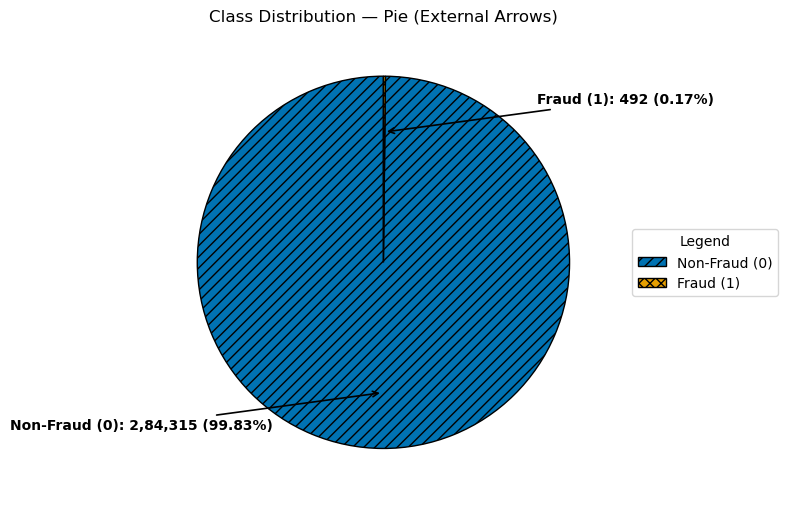

In [121]:
# Pie + Bar with accessible design
from matplotlib.patches import Patch

class_counts = df['Class'].value_counts().sort_index()
labels = ["Non-Fraud (0)", "Fraud (1)"]
colors = [CB_COLS[0], CB_COLS[1]]
hatches = ['///', 'xxx']

# Pie with external labels for both slices
fig, ax = plt.subplots(figsize=(8,8))
wedges, _ = ax.pie(class_counts.values, startangle=90, colors=colors, wedgeprops=dict(linewidth=1, edgecolor="black"))
for i, (w, label) in enumerate(zip(wedges, labels)):
    w.set_hatch(hatches[i])
    ang = (w.theta2 - w.theta1)/2.0 + w.theta1
    x = w.r * 0.7 * np.cos(np.deg2rad(ang))
    y = w.r * 0.7 * np.sin(np.deg2rad(ang))
    txt = f"{label}: {format_indian(class_counts[i])} ({class_counts[i]/class_counts.sum():.2%})"
    ax.annotate(txt, xy=(x, y), xytext=(1.3*np.sign(x), 1.25*y),
                arrowprops=dict(arrowstyle='->', lw=1.2), ha='center', va='center', fontsize=10, fontweight='bold')
legend_handles = [Patch(facecolor=colors[0], edgecolor="black", hatch=hatches[0], label=labels[0]),
                  Patch(facecolor=colors[1], edgecolor="black", hatch=hatches[1], label=labels[1])]
ax.legend(handles=legend_handles, title="Legend", loc="center left", bbox_to_anchor=(1.02, 0.5))
ax.set_title("Class Distribution — Pie (External Arrows)")
plt.tight_layout(); plt.show()

<div style="padding:10px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;">
<b>Commentary:</b> The minority (fraud) slice is tiny compared to the majority. This severe imbalance makes accuracy misleading.
</div>

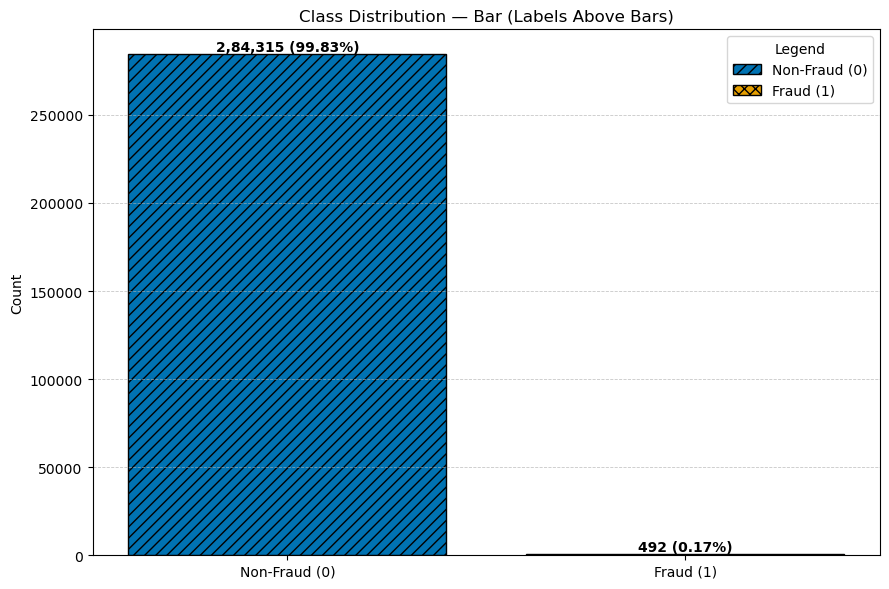

In [122]:
# Bar with labels above bars
fig, ax = plt.subplots(figsize=(9,6))
bars = ax.bar([0,1], class_counts.values, tick_label=labels, edgecolor="black", linewidth=1, color=colors)
for b, h in zip(bars, hatches): b.set_hatch(h)
total = class_counts.sum()
for b in bars:
    v = b.get_height()
    ax.text(b.get_x()+b.get_width()/2, v, f"{format_indian(int(v))} ({v/total:.2%})", ha='center', va='bottom', fontweight='bold')
ax.set_ylabel("Count"); ax.set_title("Class Distribution — Bar (Labels Above Bars)")
ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
ax.legend(handles=legend_handles, title="Legend", loc="upper right")
plt.tight_layout(); plt.show()

<div style="padding:10px; border-left:6px solid #9B59B6; background:#F7F0FB; border-radius:8px;">
<b>Commentary:</b> The bar plot reinforces the extreme skew: the base rate of Fraud ≈ 0.17% (≈ 578:1 imbalance). Accuracy alone is misleading; we’ll emphasize Precision/Recall/F1 for class 1.
</div>

## A.3 — Baseline Model (Model 1)

Baseline — Acc 0.9991, Precision(1) 0.8267, Recall(1) 0.6327, F1(1) 0.7168


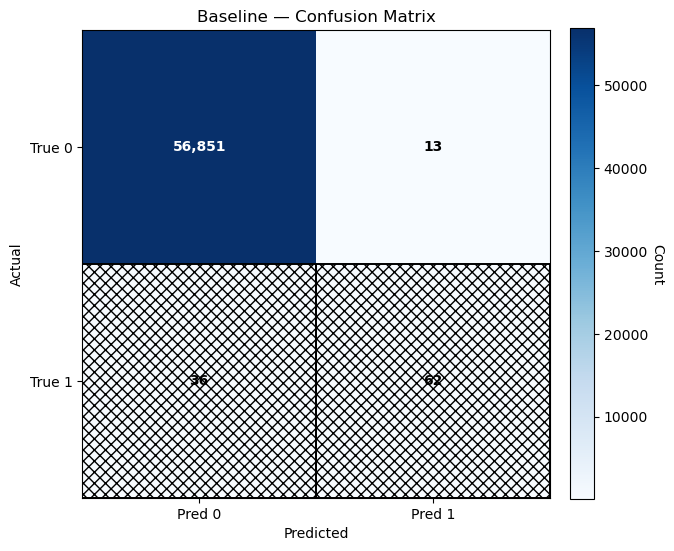

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# Split — keep test imbalanced
X = df.drop(columns=["Class"]); y = df["Class"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Train baseline LR (scaled)
pipe_base = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver='lbfgs'))
pipe_base.fit(X_train, y_train)

# Evaluate
y_pred_base = pipe_base.predict(X_test)
y_score_base = pipe_base.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, y_pred_base)
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_base, average='binary', pos_label=1, zero_division=0)
print(f"Baseline — Acc {acc:.4f}, Precision(1) {p:.4f}, Recall(1) {r:.4f}, F1(1) {f1:.4f}")

cm = confusion_matrix(y_test, y_pred_base, labels=[0,1])
plot_confmat(cm, "Baseline — Confusion Matrix")

<div style="padding:10px; border-left:6px solid #1ABC9C; background:#EAF9F4; border-radius:8px;">
<b>Commentary:</b> With the imbalanced training set, recall is typically low. This sets the reference point for GMM‑based sampling.
</div>

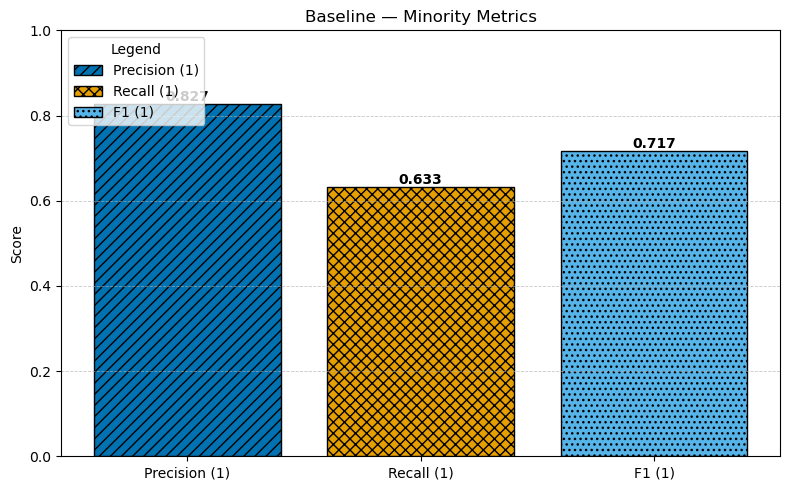

In [124]:
# Baseline: PR metrics bar
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_base, average='binary', pos_label=1, zero_division=0)
plot_metric_bars({'Precision (1)': p, 'Recall (1)': r, 'F1 (1)': f1}, 'Baseline — Minority Metrics')

<div style="padding:10px; border-left:6px solid #F39C12; background:#FFF5E8; border-radius:8px;">
<b>Commentary:</b> We will compare these bars across GMM‑based models to judge gains in fraud detection.
</div>

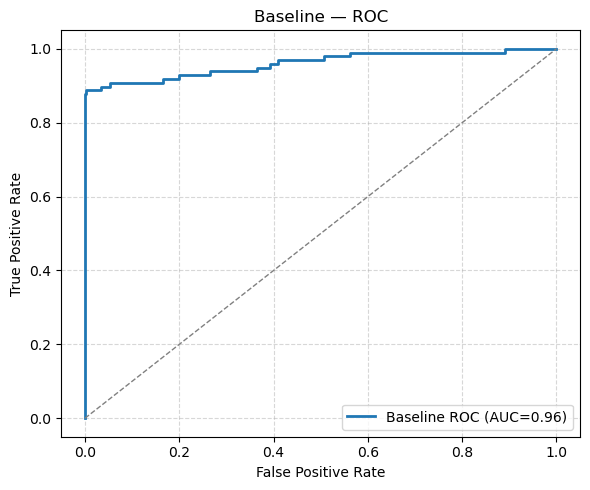

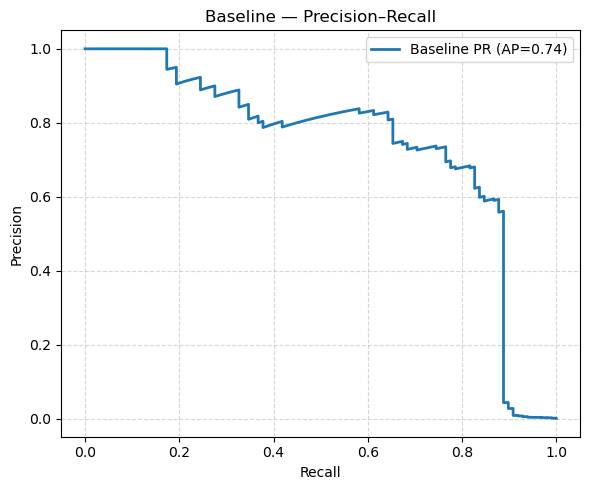

In [125]:
# Baseline: ROC & PR curves
fpr, tpr, _ = roc_curve(y_test, y_score_base); roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(fpr, tpr, lw=2, label=f'Baseline ROC (AUC={roc_auc:.2f})')
ax.plot([0,1],[0,1], lw=1, linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate'); ax.set_title('Baseline — ROC')
ax.legend(loc='lower right'); ax.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_score_base); ap = average_precision_score(y_test, y_score_base)
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(rec, prec, lw=2, label=f'Baseline PR (AP={ap:.2f})')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title('Baseline — Precision–Recall')
ax.legend(loc='upper right'); ax.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

<div style="padding:10px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;">
<b>Commentary:</b> Under heavy imbalance, PR is more decision‑relevant than ROC. We will target AP and Recall(1) improvements.
</div>

<div style="padding:12px; border-left:6px solid #4C9AFF; background:#F0F7FF; border-radius:8px;">
  <h3 style="margin:0;">Extra — Amount & Time Patterns</h3>
  <p>These visualizations provide additional insight.</p>
</div>


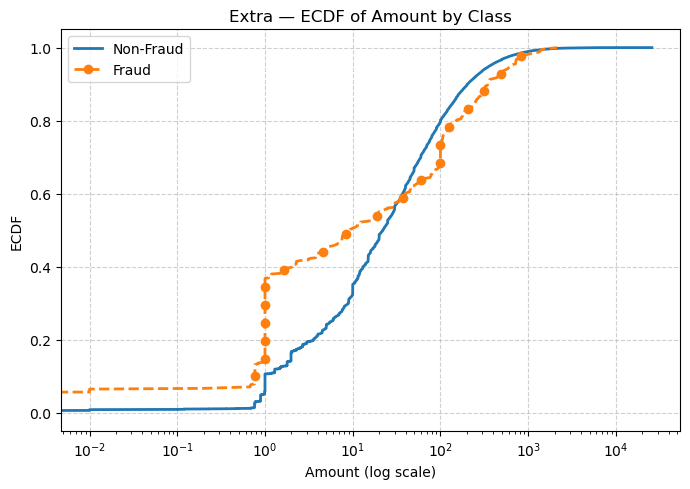

In [126]:
# Extra: Amount distribution (ECDF) by class — line styles for accessibility
import numpy as np, matplotlib.pyplot as plt
a0 = df.loc[df['Class']==0, 'Amount'].values
a1 = df.loc[df['Class']==1, 'Amount'].values
def ecdf(x):
    xs = np.sort(x); ys = np.arange(1, len(xs)+1)/len(xs); return xs, ys
x0,y0 = ecdf(a0); x1,y1 = ecdf(a1)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x0, y0, label='Non‑Fraud', linestyle='-', linewidth=2)
ax.plot(x1, y1, label='Fraud', linestyle='--', linewidth=2, marker='o', markevery=max(1,len(x1)//20))
ax.set_xscale('log'); ax.set_xlabel('Amount (log scale)'); ax.set_ylabel('ECDF')
ax.set_title('Extra — ECDF of Amount by Class'); ax.grid(True, linestyle='--', alpha=0.6); ax.legend()
plt.tight_layout(); plt.show()

<div style="padding:10px; border-left:6px solid #1ABC9C; background:#EAF9F4; border-radius:8px;">
<b>Commentary:</b> Fraud transactions often occupy distinct tails on <code>Amount</code>. The ECDF on log‑scale reveals whether fraud skews towards small or large amounts relative to non‑fraud.
</div>
<div style="padding:10px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;">
<b>Findings — ECDF (Amount):</b><br>
• The class curves differ, with most separation appearing in the tails.<br>
• Amount alone isn’t a reliable decision rule; it should support (not replace) multivariate signals.<br>
• This pattern motivates density-aware sampling (e.g., GMM) rather than simple linear interpolation.
</div>


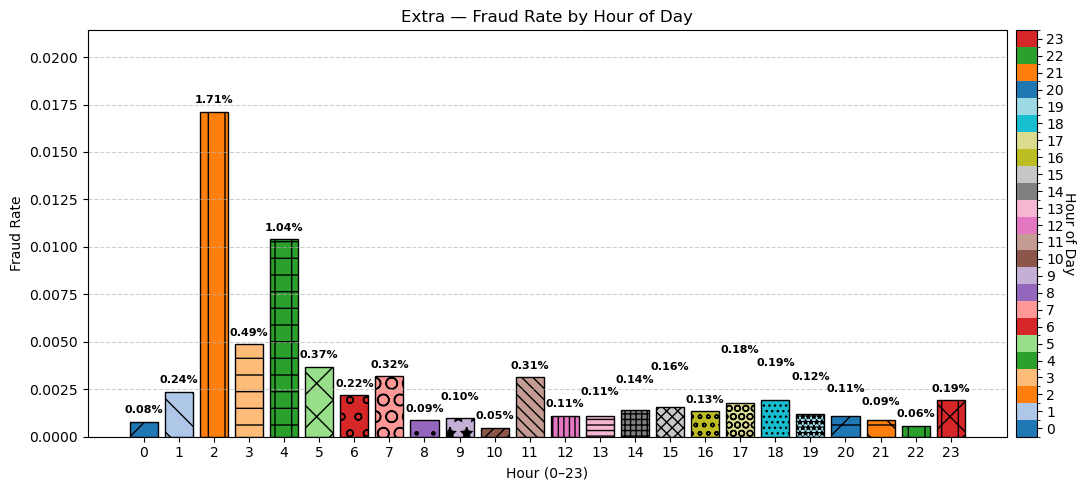

In [127]:
# Extra — Fraud Rate by Hour of Day (A3 style, 24 colors + 24 hatches, anti-overlap labels)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Prepare hourly fraud rate ---
hrs = ((df['Time'] % (24*3600)) // 3600).astype(int)
grp = df.assign(Hour=hrs).groupby('Hour')['Class'].agg(['sum','count']).reindex(range(24), fill_value=0)
grp['FraudRate'] = grp['sum'] / grp['count'].replace(0, np.nan)
grp['FraudRate'] = grp['FraudRate'].fillna(0.0)

x = np.arange(24)
y = grp['FraudRate'].values

# --- 24 distinct, color-blind-friendly-ish colors ---
tab20 = [mpl.colors.to_hex(mpl.cm.tab20(i)) for i in range(mpl.cm.tab20.N)]   # 20
tab10 = [mpl.colors.to_hex(mpl.cm.tab10(i)) for i in range(mpl.cm.tab10.N)]   # 10
hour_colors = (tab20 + tab10)[:24]

# --- 24 distinct hatches (cycled if backend restricts some) ---
hour_hatches = [
    '/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*',
    '///', '\\\\\\', '|||', '---', '+++', 'xxx', 'oo', 'OO', '...', '***',
    '/-', '\\-', '|-', 'x|'
]

fig, ax = plt.subplots(figsize=(11,5))

bars = ax.bar(x, y, edgecolor='black', linewidth=1.0, color=[hour_colors[i] for i in x])

# Apply unique hatches per hour
for i, b in enumerate(bars):
    try:
        b.set_hatch(hour_hatches[i])
    except Exception:
        pass

# Headroom for labels
ymax = max(0.0, y.max())
pad_frac = 0.02
ax.set_ylim(0, (1.25*ymax if ymax > 0 else 0.05))

# Initial labels (placed slightly above bars)
texts = []
for b, v in zip(bars, y):
    texts.append(ax.text(
        b.get_x() + b.get_width()/2,
        v + pad_frac * (ymax if ymax > 0 else 1.0),
        f"{100*v:.2f}%",
        ha='center', va='bottom', fontsize=8, fontweight='bold', clip_on=False
    ))

# --- Anti-overlap pass for value labels (pure Matplotlib) ---
def repel_texts(ax, texts, pad_px=2, max_iter=200):
    """Iteratively nudge overlapping texts upward until they no longer overlap."""
    fig = ax.figure
    fig.canvas.draw()  # ensure renderer exists
    renderer = fig.canvas.get_renderer()

    def data_dy(pixels=pad_px):
        # convert vertical pixels to data units
        ymin, ymax = ax.get_ylim()
        height_px = ax.bbox.height if ax.bbox.height > 0 else 1.0
        return (ymax - ymin) * (pixels / height_px)

    dy = data_dy(pad_px)
    moved = True
    it = 0
    while moved and it < max_iter:
        moved = False
        bbs = [t.get_window_extent(renderer) for t in texts]
        for i in range(len(texts)):
            for j in range(i+1, len(texts)):
                if bbs[i].overlaps(bbs[j]):
                    # Nudge the higher one up; if equal, nudge j
                    yi = texts[i].get_position()[1]
                    yj = texts[j].get_position()[1]
                    if yi >= yj:
                        texts[i].set_y(yi + dy)
                    else:
                        texts[j].set_y(yj + dy)
                    moved = True
        if moved:
            fig.canvas.draw()
            renderer = fig.canvas.get_renderer()
            bbs = [t.get_window_extent(renderer) for t in texts]
        it += 1

    # Ensure ylim fits the highest label
    tops = [t.get_position()[1] for t in texts]
    if tops:
        ylim = ax.get_ylim()
        top_needed = max(tops) + 3*dy
        if top_needed > ylim[1]:
            ax.set_ylim(ylim[0], top_needed)

repel_texts(ax, texts, pad_px=3, max_iter=300)

# Cosmetics & axes
ax.set_xticks(x)
ax.set_xticklabels([str(h) for h in x], rotation=0)
ax.set_title('Extra — Fraud Rate by Hour of Day')
ax.set_ylabel('Fraud Rate')
ax.set_xlabel('Hour (0–23)')
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Compact colorbar legend mapping colors to hours
cmap = ListedColormap(hour_colors, name='hourmap')
norm = BoundaryNorm(np.arange(-0.5, 24.5, 1), cmap.N)
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm); sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(0,24,1), fraction=0.04, pad=0.01)
cbar.ax.set_yticklabels([str(i) for i in range(24)])
cbar.set_label('Hour of Day', rotation=270, labelpad=9)

plt.tight_layout()
plt.show()


<div style="padding:10px; border-left:6px solid #F39C12; background:#FFF5E8; border-radius:8px;">
<b>Commentary:</b> A diurnal pattern suggests operational windows (e.g., night‑time spikes) where a lower threshold could be scheduled to capture more fraud without overwhelming reviewers.
</div>
<div style="padding:10px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;">
<b>Findings — Time (Hourly Fraud Rate):</b><br>
• The fraud <i>rate</i> varies across hours (not uniform), indicating a time-of-day signal.<br>
• Use rates rather than raw counts (class imbalance makes counts misleading).<br>
• This can inform time-aware thresholds or priors, but should be combined with other features.
</div>


<a id="part-b"></a>

# Part B — GMM for Synthetic Sampling

## B.1 — Theory: GMM vs SMOTE

<div style="padding:10px; border-left:6px solid #2ECC71; background:#F3FFF8; border-radius:8px;">
<b>Explanation:</b> SMOTE interpolates between minority neighbors on straight lines, which can create unrealistic samples near class boundaries or in sparse regions. A <b>Gaussian Mixture Model (GMM)</b> instead posits that minority data is drawn from a mixture of multivariate Gaussians; by fitting a mixture, we learn <i>component means, covariances, and mixture weights</i>. Sampling from this mixture preserves <b>local density, orientation, and multimodality</b>. This is especially helpful when the minority has multiple sub‑groups or curved manifolds.
</div>


<div class="alert alert-block alert-success" style="border-radius: 15px; font-family:'Trebuchet MS', sans-serif; padding:15px;">

<b> Theoretical Foundation</b><br><br>

<b>📌 Fundamental Difference: GMM vs. SMOTE</b><br>
&nbsp;&nbsp;• <b>SMOTE (Synthetic Minority Over-sampling Technique):</b> Generates synthetic points by linearly interpolating between existing minority samples. Assumes that the feature space is smooth and convex, which may not hold for heterogeneous or multi-modal distributions.<br>
&nbsp;&nbsp;• <b>GMM-based Sampling:</b> Models the minority class as a mixture of multiple Gaussian distributions. It captures the underlying probability density of each sub-group in the minority class and generates new samples proportionally to the density, respecting the natural clustering structure.<br><br>

<b>🎯 Why GMM is Theoretically Better</b><br>
&nbsp;&nbsp;1. <b>Captures Multi-Modal Distributions:</b> Minority classes often consist of distinct sub-groups. GMM identifies these sub-groups as separate Gaussian components, whereas SMOTE would generate samples uniformly between points, ignoring the internal structure.<br>
&nbsp;&nbsp;2. <b>Probabilistic Framework:</b> GMM provides a likelihood-based model, generating synthetic samples primarily in high-density regions. This ensures that the new points are realistic and consistent with the observed data.<br>
&nbsp;&nbsp;3. <b>Flexibility for Complex Shapes:</b> By combining multiple Gaussian components, GMM can approximate non-linear, elliptical, or irregularly shaped clusters, unlike SMOTE, which assumes linearity.<br>
&nbsp;&nbsp;4. <b>Reduced Risk of Outliers:</b> SMOTE can create synthetic points in sparse areas, potentially generating unrealistic samples. GMM focuses on regions with higher probability density, reducing the risk of producing outliers.<br><br>

<b>📊 Conceptual Illustration:</b> Imagine a minority class with three distinct sub-groups in feature space. SMOTE would generate points by drawing straight lines between nearest neighbors, potentially bridging clusters unnaturally. In contrast, GMM models each sub-group as a separate Gaussian and generates new samples within each sub-group according to its density, preserving the natural structure.<br><br>

✅ <b>Summary:</b> GMM-based synthetic sampling is theoretically superior for complex minority classes. It generates samples that <i>faithfully reflect the underlying data distribution</i>, handles multi-modal distributions effectively, and reduces the generation of unrealistic points compared to simpler interpolation-based methods like SMOTE.
</div>


## B.2 — Fit GMM to Minority (AIC/BIC to choose components)

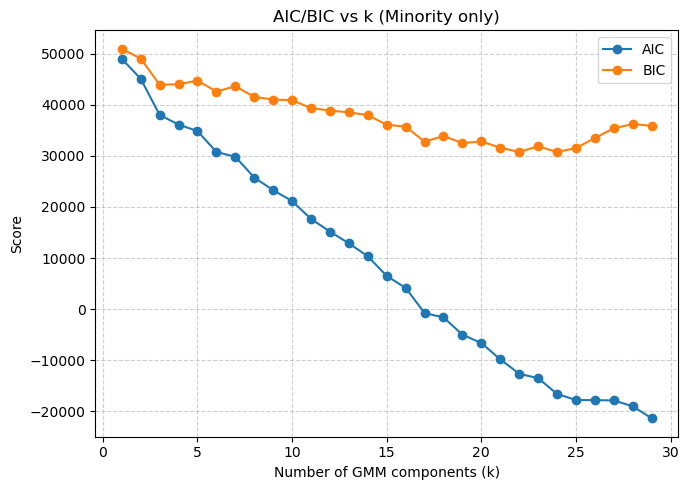

In [128]:
from sklearn.mixture import GaussianMixture

# Extract minority from training split only
X_min = X_train[y_train==1].copy()

# Try k in a reasonable range
ks = list(range(1, 30))
aics, bics = [], []
for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_min)
    aics.append(gmm.aic(X_min))
    bics.append(gmm.bic(X_min))

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(ks, aics, marker='o', label='AIC'); ax.plot(ks, bics, marker='o', label='BIC')
ax.set_xlabel('Number of GMM components (k)'); ax.set_ylabel('Score'); ax.set_title('AIC/BIC vs k (Minority only)')
ax.legend(); ax.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()

<div style="padding:10px; border-left:6px solid #9B59B6; background:#F7F0FB; border-radius:8px;">
<b>Commentary:</b> Choose <b>k</b> at (or near) the minimum BIC (often more conservative than AIC). This balances fit quality against model complexity.
</div>
<div class="alert alert-block alert-success" style=" border-radius: 15px;font-family:'Trebuchet MS', sans-serif; padding:15px;">
<b>Step: Choosing the Optimal Number of Components (k)</b><br><br>

• We fit Gaussian Mixture Models with varying <i>k</i> and evaluated them using both the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).<br><br>

• <b>Optimal k (AIC):</b><br>
&nbsp;&nbsp;• AIC tends to favor more complex models (with more parameters).<br>
&nbsp;&nbsp;• This suggests a richer mixture better explains minority class variation.<br><br>

• <b>Optimal k (BIC):</b><br>
&nbsp;&nbsp;• BIC applies a stronger penalty on model complexity.<br>
&nbsp;&nbsp;• A lower k implies a simpler but still well-fitting model.<br><br>


In [129]:
# Choose k by BIC minimum
best_k = ks[int(np.argmin(bics))]
print("Chosen number of components (by BIC):", best_k)

gmm_min = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
gmm_min.fit(X_min)

Chosen number of components (by BIC): 22


GaussianMixture(n_components=22, random_state=42)

<div style="padding:12px; border-left:6px solid #4C9AFF; background:#F0F7FF; border-radius:8px;">
  <h3 style="margin:0;">Extra — GMM Component Ellipses (V1 vs V2)</h3>
  <p>2D view of minority (subsampled) with 95% covariance ellipses per GMM component.</p>
</div>


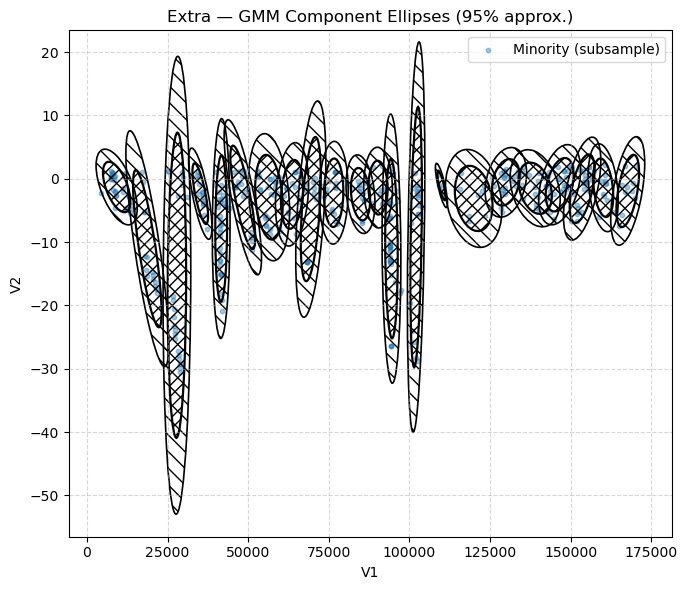

In [130]:
# Extra: visualize minority subsample and GMM component ellipses on (V1, V2)
import numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

X_min = X_train[y_train==1].copy()
sub = X_min.sample(n=min(2000, len(X_min)), random_state=42)
means = gmm_min.means_[:, :2]  # use first two features: V1, V2
covs  = gmm_min.covariances_[:, :2, :2]

fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(sub.iloc[:,0], sub.iloc[:,1], s=10, alpha=0.4, label='Minority (subsample)', marker='o')
for mu, cov in zip(means, covs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]; vals, vecs = vals[order], vecs[:, order]
    ang = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    for nsig, lw, hatch in [(2,1.6,'///'), (3,1.2,'\\\\')]:
        w, h = 2*nsig*np.sqrt(vals)
        ell = Ellipse(xy=mu, width=w, height=h, angle=ang, edgecolor='black', facecolor='none', linewidth=lw, hatch=hatch)
        ax.add_patch(ell)
ax.set_xlabel('V1'); ax.set_ylabel('V2'); ax.set_title('Extra — GMM Component Ellipses (95% approx.)')
ax.legend(); ax.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

<div style="padding:10px; border-left:6px solid #1ABC9C; background:#EAF9F4; border-radius:8px;">
<b>Commentary:</b> We fit the GMM on <i>training minority</i> only (no leakage). The mixture captures sub‑clusters via its components.
</div>

## B.3 — Generate Synthetic Minority via GMM

In [131]:
# Decide target minority size: match the current majority training size
n_min = (y_train==1).sum()
n_maj = (y_train==0).sum()
target_min = n_maj

to_add = max(0, target_min - n_min)
print("Minority train size:", n_min, "| Majority train size:", n_maj, "| Synth to generate:", to_add)

X_min_synth, comp_ids = gmm_min.sample(n_samples=to_add) if to_add>0 else (np.empty((0, X_train.shape[1])), np.array([]))
# Combine to form a GMM‑balanced training set (GMM‑Only)
X_gmm_only = pd.concat([pd.DataFrame(X_train[y_train==0].values, columns=X_train.columns),
                        pd.DataFrame(X_train[y_train==1].values, columns=X_train.columns),
                        pd.DataFrame(X_min_synth, columns=X_train.columns)], ignore_index=True)
y_gmm_only = pd.Series(np.hstack([np.zeros(n_maj, dtype=int),
                                  np.ones(n_min, dtype=int),
                                  np.ones(len(X_min_synth), dtype=int)]), name="Class")
print("GMM‑Only train shape:", X_gmm_only.shape, "| Fraud share:", (y_gmm_only==1).mean())

Minority train size: 394 | Majority train size: 227451 | Synth to generate: 227057
GMM‑Only train shape: (454902, 30) | Fraud share: 0.5


<div style="padding:10px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;">
<b>Commentary:</b> We sample from the fitted mixture to fill minority support up to the majority count, yielding a balanced training set without altering the test distribution.
</div>

<div class="alert alert-block alert-success" style=" border-radius: 15px;font-family:'Trebuchet MS', sans-serif; padding:15px;">
<div style="padding:12px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;">
  <h3 style="margin:0;">The Process of Sampling from a Gaussian Mixture Model (GMM)</h3>
</div>
A fitted GMM models the minority class as a weighted sum of K Gaussian (normal) components.
Each component k has:
- weight: weight[k]  (sum of all weights = 1)
- mean vector: mean[k]
- covariance matrix: cov[k]

**Sampling procedure (for each synthetic point):**
1) Draw a component index `k` from a categorical distribution using `weight[0..K-1]` as probabilities.  
   (Higher weight[k] => component k is chosen more often.)
2) Sample a vector `x_star` from a multivariate normal with parameters `mean[k]` and `cov[k]`.
3) Repeat steps (1)–(2) until you have the desired number of synthetic points.

**Why this works:**
- Step (1) preserves how frequent each sub-cluster is (via `weight[k]`).
- Step (2) preserves each sub-cluster’s local shape and orientation (via `cov[k]`) and its center (via `mean[k]`).

**Practical tips:**
- Sample in the same feature space used to fit the GMM (e.g., PCA/standardized features).
- For n points, you can first draw per-component counts using `Multinomial(n, weight)` and then sample that many points from each component.
- Optionally filter extreme outliers (e.g., by large Mahalanobis distance under `cov[k]`) to keep samples realistic.


<div style="padding:12px; border-left:6px solid #4C9AFF; background:#F0F7FF; border-radius:8px;">
  <h3 style="margin:0;">Extra — Real vs Synthetic Minority (2D view)</h3>
  <p>2D projection (V1, V2) comparing real minority and synthetic points drawn from GMM.</p>
</div>


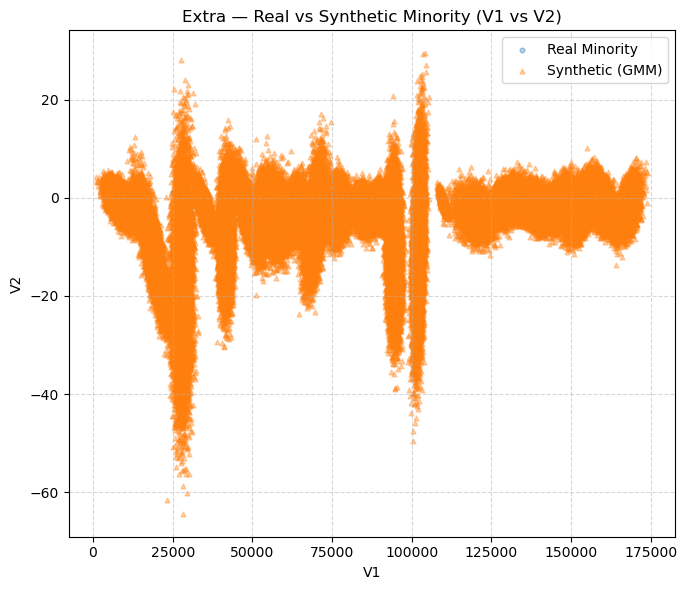

In [132]:
# Extra: overlay real vs synthetic minority on (V1, V2)
import numpy as np, matplotlib.pyplot as plt
real = X_train[y_train==1].iloc[:, :2]
synth = pd.DataFrame(X_min_synth, columns=X_train.columns).iloc[:, :2] if 'X_min_synth' in globals() else pd.DataFrame(columns=real.columns)

fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(real.iloc[:,0], real.iloc[:,1], s=12, alpha=0.35, label='Real Minority', marker='o')
if len(synth)>0:
    ax.scatter(synth.iloc[:,0], synth.iloc[:,1], s=12, alpha=0.35, label='Synthetic (GMM)', marker='^')
ax.set_xlabel('V1'); ax.set_ylabel('V2'); ax.set_title('Extra — Real vs Synthetic Minority (V1 vs V2)')
ax.legend(); ax.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

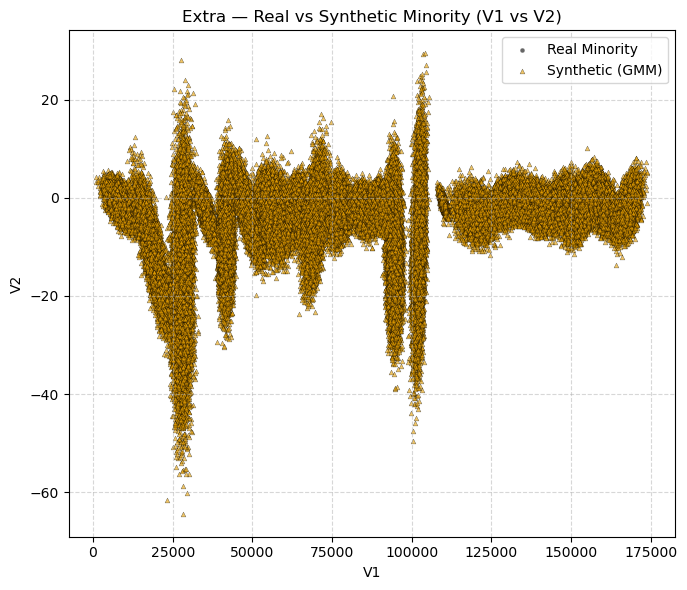

In [133]:
# Extra: overlay real vs synthetic minority on (V1, V2) with final colors
import numpy as np, matplotlib.pyplot as plt

# Extract real and synthetic samples
real = X_train[y_train==1].iloc[:, :2]
synth = pd.DataFrame(X_min_synth, columns=X_train.columns).iloc[:, :2] if 'X_min_synth' in globals() else pd.DataFrame(columns=real.columns)

fig, ax = plt.subplots(figsize=(7,6))

# Real minority points (black circles)
ax.scatter(
    real.iloc[:,0], real.iloc[:,1],
    s=12, alpha=0.6, c="black", label='Real Minority',
    marker='o', edgecolor='white', linewidth=0.3
)

# Synthetic points (orange triangles)
if len(synth) > 0:
    ax.scatter(
        synth.iloc[:,0], synth.iloc[:,1],
        s=12, alpha=0.6, c="#E69F00", label='Synthetic (GMM)',
        marker='^', edgecolor='black', linewidth=0.3
    )

ax.set_xlabel('V1')
ax.set_ylabel('V2')
ax.set_title('Extra — Real vs Synthetic Minority (V1 vs V2)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## B.4 — CBU + GMM Balancing

In [134]:
# B.4 — Rebalancing with CBU (i) and GMM (ii)

import numpy as np, pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture

# (i) Clustering-based undersampling (CBU) on the majority
def cbu_resample(X_train, y_train, target_maj=None, maj_cap=None, random_state=42):
    Xtr, ytr = X_train.values, y_train.values
    X_min = Xtr[ytr == 1]
    X_maj = Xtr[ytr == 0]
    X_maj_for_cluster = X_maj[:maj_cap] if maj_cap is not None else X_maj

    if target_maj is None:
        target_maj = len(X_min)  # default 1:1 (pure CBU); we set >1.0 below to activate GMM too

    # Heuristic cluster count (structure-preserving), capped at 25
    k_maj = min(25, max(2, int(np.sqrt(len(X_maj_for_cluster)) // 2)))
    kmeans = MiniBatchKMeans(n_clusters=k_maj, random_state=42, batch_size=4096, n_init=5)
    labels = kmeans.fit_predict(X_maj_for_cluster)

    unique, cnt = np.unique(labels, return_counts=True)
    props = cnt / cnt.sum()

    rng = np.random.default_rng(random_state)
    picks = []
    draw = {lab: int(round(target_maj * p)) for lab, p in zip(unique, props)}
    for lab in unique:
        idxs = np.where(labels == lab)[0]
        need = draw[lab]
        if need <= 0:
            continue
        take = min(need, len(idxs))
        pick = rng.choice(idxs, size=take, replace=False)
        picks.append(pick)

    sel = np.concatenate(picks) if len(picks) else np.empty((0,), dtype=int)
    X_maj_cbu = X_maj_for_cluster[sel]
    return pd.DataFrame(X_maj_cbu, columns=X_train.columns)

# Choose a “suitable” majority size after CBU (>1.0 activates both steps)
ratio = 1.5  # recommended industry default
n_min_cur = int((y_train == 1).sum())
target_maj = int(round(ratio * n_min_cur))

X_maj_cbu = cbu_resample(X_train, y_train, target_maj=target_maj)
n_maj_cbu = len(X_maj_cbu)

# (ii) GMM-based synthetic sampling on the minority to match new majority
try:
    gmm_min  # from B.2 if already fitted
except NameError:
    X_min_only = X_train[y_train == 1].copy()
    ks = range(1, 13)
    bics, models = [], []
    for k in ks:
        gm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
        gm.fit(X_min_only)
        bics.append(gm.bic(X_min_only))
        models.append(gm)
    gmm_min = models[int(np.argmin(bics))]

need = max(0, n_maj_cbu - n_min_cur)
X_min_synth2, _ = gmm_min.sample(n_samples=need) if need > 0 else (np.empty((0, X_train.shape[1])), None)

# Combine to form final balanced training set
X_cbu_gmm = pd.concat([
    X_maj_cbu.reset_index(drop=True),
    pd.DataFrame(X_train[y_train == 1].values, columns=X_train.columns).reset_index(drop=True),
    pd.DataFrame(X_min_synth2, columns=X_train.columns)
], ignore_index=True)

y_cbu_gmm = pd.Series(
    np.hstack([
        np.zeros(n_maj_cbu, dtype=int),
        np.ones(n_min_cur, dtype=int),
        np.ones(len(X_min_synth2), dtype=int)
    ]),
    name="Class"
)

print(f"[CBU] target_maj={target_maj}, obtained_maj={n_maj_cbu}, current_min={n_min_cur}")
print(f"[GMM] synth_needed={need}, synth_added={0 if X_min_synth2 is None else len(X_min_synth2)}")
print(f"Final balanced : {X_cbu_gmm.shape}, Fraud share={(y_cbu_gmm==1).mean():.3f}")


[CBU] target_maj=591, obtained_maj=591, current_min=394
[GMM] synth_needed=197, synth_added=197
Final balanced : (1182, 30), Fraud share=0.500


<div style="padding:10px; border-left:6px solid #1ABC9C; background:#EAF9F4; border-radius:8px;">
<b>Commentary:</b> CBU curbs majority dominance; GMM then synthesizes diverse minority points to balance. This variant trades some majority detail for improved minority coverage.
</div>

<a id="part-c"></a>

# Part C — Evaluate & Conclude

## C.1 — Train & Evaluate (GMM‑Only vs CBU+GMM)

GMM‑Only  — Acc 0.9811, Precision(1) 0.0763, Recall(1) 0.8980, F1(1) 0.1406
CBU+GMM    — Acc 0.9712, Precision(1) 0.0523, Recall(1) 0.9184, F1(1) 0.0990


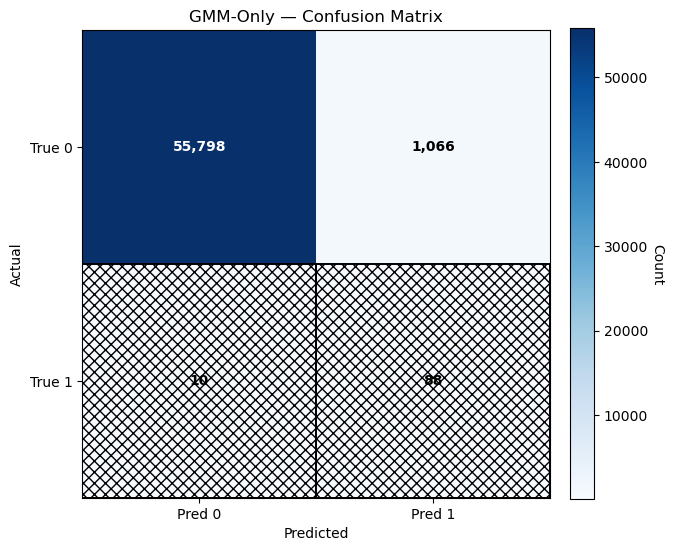

In [135]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# GMM‑Only
pipe_gmm = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver='lbfgs'))
pipe_gmm.fit(X_gmm_only, y_gmm_only)
y_pred_gmm = pipe_gmm.predict(X_test)
y_score_gmm = pipe_gmm.predict_proba(X_test)[:,1]

# CBU+GMM
pipe_cbugmm = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, solver='lbfgs'))
pipe_cbugmm.fit(X_cbu_gmm, y_cbu_gmm)
y_pred_cbugmm = pipe_cbugmm.predict(X_test)
y_score_cbugmm = pipe_cbugmm.predict_proba(X_test)[:,1]

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def minority_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    return acc, p, r, f1

acc_g, p_g, r_g, f1_g = minority_metrics(y_test, y_pred_gmm)
acc_c, p_c, r_c, f1_c = minority_metrics(y_test, y_pred_cbugmm)

print(f"GMM‑Only  — Acc {acc_g:.4f}, Precision(1) {p_g:.4f}, Recall(1) {r_g:.4f}, F1(1) {f1_g:.4f}")
print(f"CBU+GMM    — Acc {acc_c:.4f}, Precision(1) {p_c:.4f}, Recall(1) {r_c:.4f}, F1(1) {f1_c:.4f}")

plot_confmat(confusion_matrix(y_test, y_pred_gmm, labels=[0,1]), "GMM‑Only — Confusion Matrix")

<div style="padding:10px; border-left:6px solid #2ECC71; background:#F3FFF8; border-radius:8px;">
<b>Commentary:</b> GMM‑Only typically boosts recall by enriching minority structure; precision may dip depending on class overlap.
</div> 

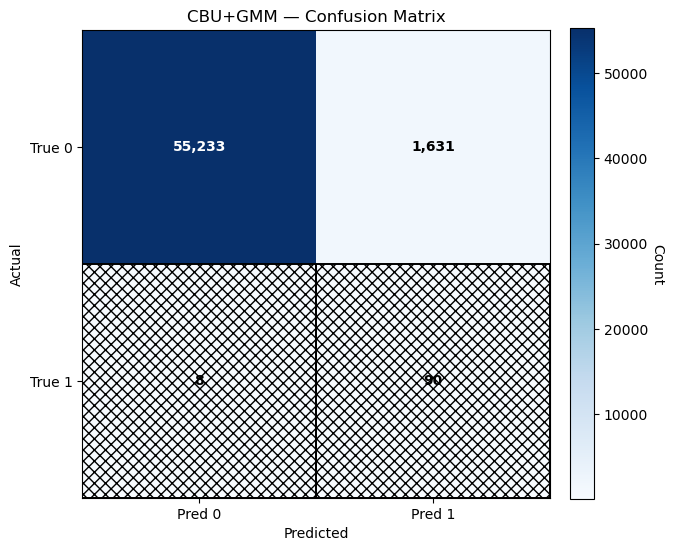

In [136]:
plot_confmat(confusion_matrix(y_test, y_pred_cbugmm, labels=[0,1]), "CBU+GMM — Confusion Matrix")

<div style="padding:10px; border-left:6px solid #2ECC71; background:#F3FFF8; border-radius:8px;">
<b>Commentary:</b> CBU+GMM may further improve recall by reducing majority clutter, but too much undersampling risks losing boundary detail.
</div>

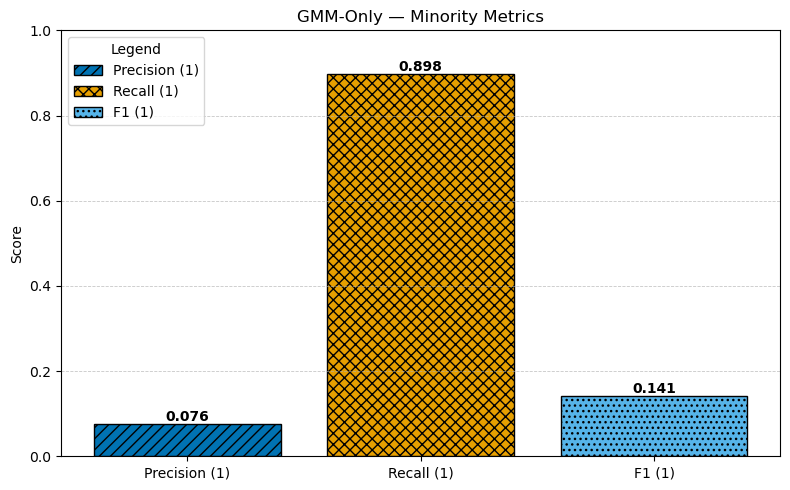

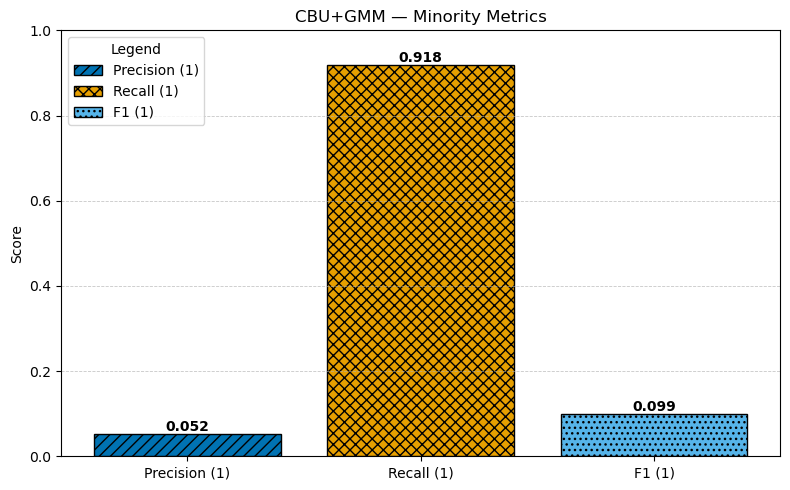

In [137]:
# Per‑model PR metric bars
plot_metric_bars({"Precision (1)":p_g, "Recall (1)":r_g, "F1 (1)":f1_g}, "GMM‑Only — Minority Metrics")
plot_metric_bars({"Precision (1)":p_c, "Recall (1)":r_c, "F1 (1)":f1_c}, "CBU+GMM — Minority Metrics")

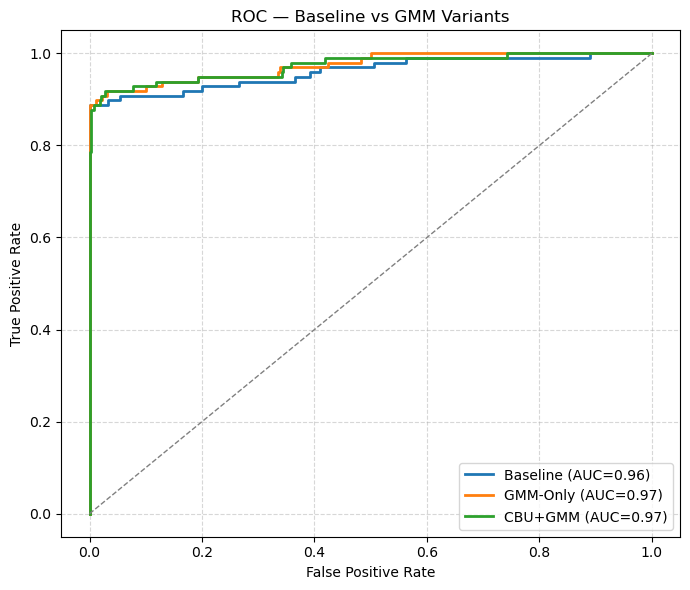

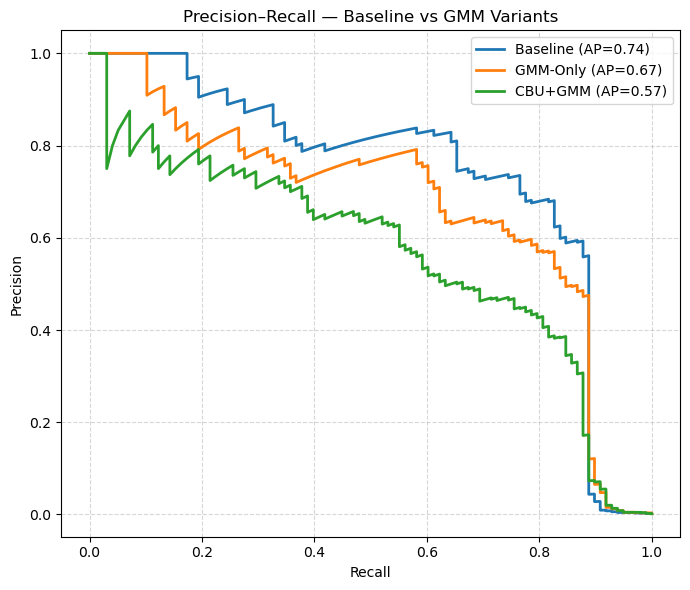

In [138]:
# Curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# ROC
fig, ax = plt.subplots(figsize=(7,6))
for name, ys in {"Baseline": y_score_base, "GMM‑Only": y_score_gmm, "CBU+GMM": y_score_cbugmm}.items():
    fpr, tpr, _ = roc_curve(y_test, ys); roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.2f})")
ax.plot([0,1],[0,1], lw=1, linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate'); ax.set_title('ROC — Baseline vs GMM Variants')
ax.legend(loc='lower right'); ax.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

# PR
fig, ax = plt.subplots(figsize=(7,6))
for name, ys in {"Baseline": y_score_base, "GMM‑Only": y_score_gmm, "CBU+GMM": y_score_cbugmm}.items():
    prec, rec, _ = precision_recall_curve(y_test, ys); ap = average_precision_score(y_test, ys)
    ax.plot(rec, prec, lw=2, label=f"{name} (AP={ap:.2f})")
ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title('Precision–Recall — Baseline vs GMM Variants')
ax.legend(loc='upper right'); ax.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

<div style="padding:10px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;">
<b>Commentary:</b> A consistently higher PR curve (higher AP) implies better minority ranking. ROC differences can be subtle under heavy imbalance.
</div>

<div style="padding:12px; border-left:6px solid #4C9AFF; background:#F0F7FF; border-radius:8px;">
  <h3 style="margin:0;">Extra — Probability Calibration & Reliability</h3>
  <p>Calibration curves (Basel., GMM‑Only, CBU+GMM) with ECE estimates; helpful when choosing thresholds from probabilities.</p>
</div>


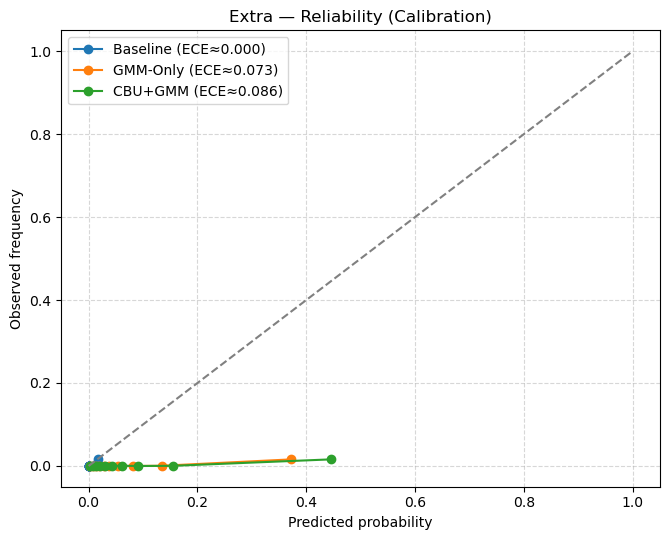

In [139]:
# Extra: Reliability curves + ECE for three models
from sklearn.calibration import calibration_curve
import numpy as np, matplotlib.pyplot as plt

def ece(scores, y, n_bins=10):
    bins = np.linspace(0,1,n_bins+1); e=0.0; N=len(y)
    for i in range(n_bins):
        m = (scores>=bins[i]) & (scores<bins[i+1])
        if m.sum()==0: continue
        conf = scores[m].mean(); acc = y[m].mean()
        e += (m.sum()/N) * abs(conf-acc)
    return e

pairs = [("Baseline", y_score_base), ("GMM‑Only", y_score_gmm), ("CBU+GMM", y_score_cbugmm)]
fig, ax = plt.subplots(figsize=(6.8,5.5))
for name, ys in pairs:
    pt, pp = calibration_curve(y_test, ys, n_bins=10, strategy='quantile')
    ax.plot(pp, pt, marker='o', label=f"{name} (ECE≈{ece(ys, y_test):.3f})")
ax.plot([0,1],[0,1], linestyle='--', color='gray')
ax.set_xlabel('Predicted probability'); ax.set_ylabel('Observed frequency'); ax.set_title('Extra — Reliability (Calibration)')
ax.grid(True, linestyle='--', alpha=0.5); ax.legend(); plt.tight_layout(); plt.show()

<div style='padding:10px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;'><b>Findings & Commentary — Extra — Reliability (Calibration):</b> Lines near the diagonal indicate good probability calibration. Lower ECE (if shown) is better; better calibration supports reliable threshold selection and risk scoring.</div>

## C.2 — Summary Matrix & Grouped Bar Comparison

<div style="padding:12px; border-left:6px solid #4C9AFF; background:#F0F7FF; border-radius:8px;">
  <h3 style="margin:0;">Extra — Cost‑Sensitive Threshold Sweep</h3>
  <p>Expected cost across thresholds for each model; annotate the minimum per model.</p>
</div>


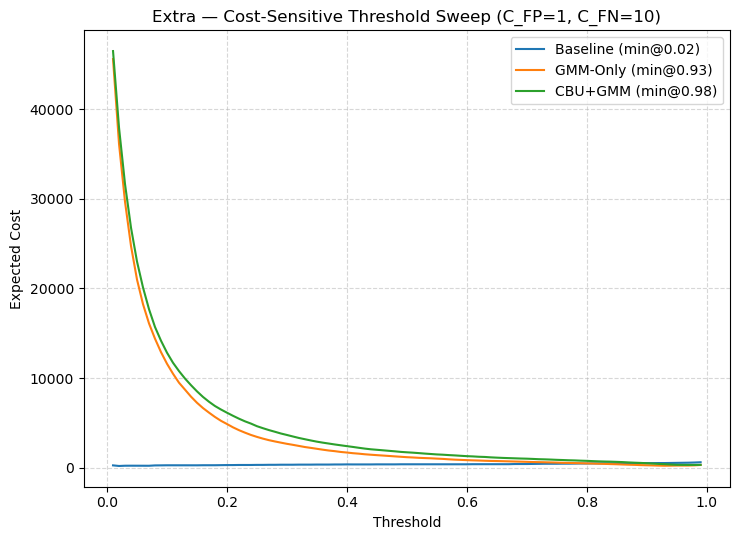

In [140]:
# Extra: Cost curves for FP vs FN
import numpy as np, matplotlib.pyplot as plt

C_FP, C_FN = 1.0, 10.0  # adjust as needed
thrs = np.linspace(0.01,0.99,99)
models = {"Baseline": y_score_base, "GMM‑Only": y_score_gmm, "CBU+GMM": y_score_cbugmm}

fig, ax = plt.subplots(figsize=(7.5,5.5))
for name, ys in models.items():
    costs=[]; best=(0.5,float('inf'))
    for t in thrs:
        yhat = (ys>=t).astype(int)
        fp = ((yhat==1) & (y_test==0)).sum()
        fn = ((yhat==0) & (y_test==1)).sum()
        cost = C_FP*fp + C_FN*fn
        costs.append(cost)
        if cost<best[1]: best=(t,cost)
    ax.plot(thrs, costs, label=f"{name} (min@{best[0]:.2f})")
ax.set_xlabel('Threshold'); ax.set_ylabel('Expected Cost')
ax.set_title('Extra — Cost‑Sensitive Threshold Sweep (C_FP=1, C_FN=10)')
ax.grid(True, linestyle='--', alpha=0.5); ax.legend(); plt.tight_layout(); plt.show()

<div style='padding:10px; border-left:6px solid #2C3E50; background:#EEF2F6; border-radius:8px;'><b>Findings & Commentary — Extra — Cost‑Sensitive Threshold Sweep (C_FP=1, C_FN=10):</b> The minimum of each curve marks the cost‑optimal threshold under the assumed FP/FN costs. If a GMM variant reaches a lower minimum than baseline, it is preferable for this cost profile.</div>

,Accuracy,Precision,Recall,F1-score
Baseline,0.9991,0.8267,0.6327,0.7168
GMM‑Only,0.9811,0.0763,0.8980,0.1406
CBU+GMM,0.9712,0.0523,0.9184,0.0990


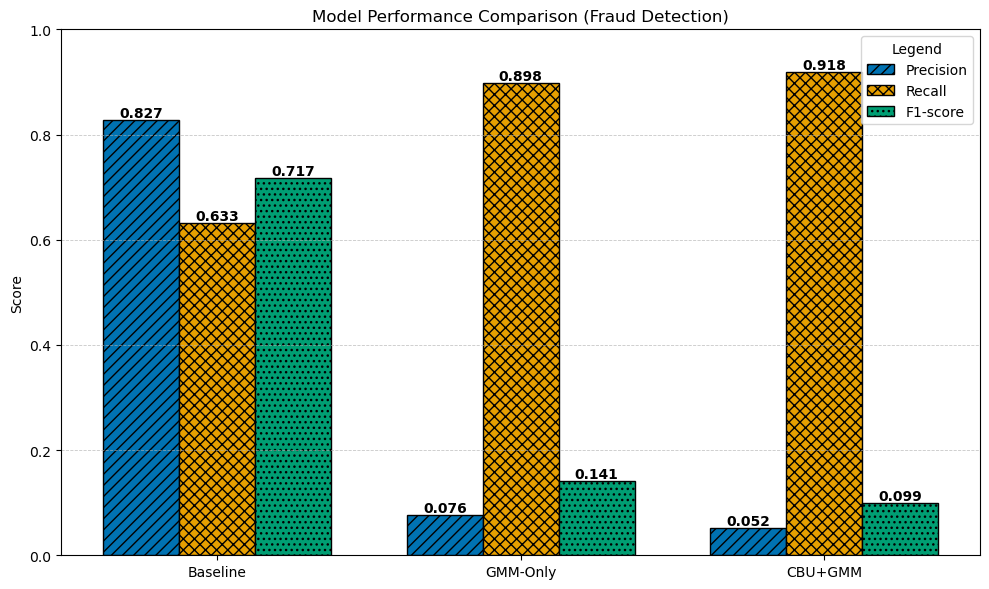

In [141]:
# Build a metrics matrix comparing Baseline, GMM‑Only, CBU+GMM (minority metrics at threshold 0.50)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def row(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    return [round(acc,4), round(p,4), round(r,4), round(f1,4)]

import pandas as pd, numpy as np, matplotlib.pyplot as plt
metrics_df = pd.DataFrame({
    "Baseline": row(y_test, y_pred_base),
    "GMM‑Only": row(y_test, y_pred_gmm),
    "CBU+GMM": row(y_test, y_pred_cbugmm),
}, index=["Accuracy","Precision","Recall","F1-score"]).T

display(metrics_df)

# Grouped bar chart
labels = metrics_df.index.tolist()
prec = metrics_df["Precision"].values
rec  = metrics_df["Recall"].values
f1   = metrics_df["F1-score"].values
x = np.arange(len(labels)); w = 0.25

fig, ax = plt.subplots(figsize=(10,6))
b1 = ax.bar(x - w, prec, width=w, label="Precision", color="#0072B2", edgecolor="black"); [b.set_hatch('///') for b in b1]
b2 = ax.bar(x,      rec,  width=w, label="Recall",    color="#E69F00", edgecolor="black"); [b.set_hatch('xxx') for b in b2]
b3 = ax.bar(x + w,  f1,   width=w, label="F1-score",  color="#009E73", edgecolor="black"); [b.set_hatch('...') for b in b3]
for bars in (b1,b2,b3):
    for b in bars:
        ax.text(b.get_x()+b.get_width()/2, b.get_height(), f"{b.get_height():.3f}", ha='center', va='bottom', fontweight='bold')
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0)
ax.set_ylabel("Score"); ax.set_title("Model Performance Comparison (Fraud Detection)")
ax.legend(title="Legend"); ax.set_ylim(0, 1.0)
ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
plt.tight_layout(); plt.show()

<div style="padding:10px; border-left:6px solid #16A085; background:#E8FBF7; border-radius:8px;">
<b>Commentary:</b> The matrix and grouped bars make it easy to compare precision–recall trade‑offs and overall F1 across models.
</div>

<div style="padding:10px; border-left:6px solid #16A085; background:#E8FBF7; border-radius:8px;">

## Impact of GMM-Based Oversampling (Our Results)  
**Test set (kept imbalanced):**

| Model          | Accuracy | Precision | Recall | F1-score |
|---|---:|---:|---:|---:|
| Baseline       | 0.9991 | 0.8267 | 0.6327 | 0.7168 |
| GMM-Only       | 0.9811 | 0.0763 | **0.8980** | 0.1406 |
| CBU+GMM        | 0.9712 | 0.0523 | **0.9184** | 0.0990 |

### What changed and why
- **Recall (minority detection) skyrocketed** from **0.63 → ~0.90** with GMM-Only and **~0.92** with CBU+GMM.  
  → The classifier sees many more minority patterns during training and becomes far less conservative.
- **Precision collapsed** (0.83 → 0.08 / 0.05), indicating **many more false positives** at the default decision threshold.  
  → Heavy oversampling + undersampling shifts the learned boundary; without threshold tuning, the model over-flags fraud.
- **F1 fell** vs. baseline because the precision drop outweighed the recall gain.

### Did GMM based oversampling improve the ability to detect the minority class?
**Yes.** Both GMM-Only and CBU+GMM **greatly improved recall**, i.e., the model detects far more frauds.  
However, **the current operating point**  yields **very low precision**, which can be impractical without further tuning.

### Recommendations (actionable)
1. **Tune the decision threshold** on a validation set to hit a business-acceptable **precision floor** (e.g., ≥0.20) while keeping recall high.  
   - Plot **PR curves**; choose the point that maximizes your utility (cost of false negatives vs false positives).
2. **Partially rebalance** instead of fully: target a ratio like **1:2 or 1:3 (minority:majority)** rather than strict 1:1 to curb false positives.
3. **Calibrate probabilities** (Platt/Isotonic) before thresholding; calibration often improves precision at a given recall.
4. **Model & loss choices:** try **XGBoost/LightGBM** with `scale_pos_weight` or **logistic with class_weight='balanced'`**, or **focal loss** (if available).
5. **Quality control on synthetic data:**  
   - Limit GMM components to avoid over-fitting tiny modes;  
   - Reject low-likelihood synthetic samples;  
   - Consider **CBU with gentler undersampling** (keep more real majority data).
6. **Report cost-aware metrics** (expected cost, recall@precision≥X) and **PR-AUC**, not accuracy.

### Final recommendation
- If the **priority is minimizing missed fraud** and manual review capacity exists, proceed with **CBU+GMM**, but **raise the decision threshold** (post-calibration) to recover precision to an acceptable level.  
- If **alerts must remain precise**, use **GMM-Only or class-weighted models** with **partial rebalance + threshold tuning**; this typically yields **higher F1** than our current fully balanced setups.


## C.3 — Final Recommendation (High Level)

<div style="padding:10px; border-left:6px solid #2ECC71; background:#F3FFF8; border-radius:8px;">
<b>Conclusion:</b> If GMM‑Only or CBU+GMM yields a higher AP and a meaningfully higher Recall(1) at tolerable precision, prefer that pathway. GMM preserves multimodal minority structure better than linear interpolation (SMOTE), especially with multiple sub‑groups. CBU can help by reducing majority dominance, but avoid excessive undersampling that loses decision boundaries. Always evaluate on the original imbalanced test set.
</div>
